In [1]:
import numpy as np

from sklearn import linear_model, datasets

from sklearn.metrics import classification_report

from sklearn.neural_network import BernoulliRBM

from keras.models import Sequential

from keras.layers import Dense, Activation

from keras.callbacks import ModelCheckpoint, TensorBoard

import os

import json

import pickle

Using TensorFlow backend.


In [2]:
class DBN():



  def __init__(

    self,

    train_data,

    targets, 

    layers,

    outputs,

    rbm_lr,

    rbm_iters,

    rbm_dir=None,

    test_data = None,

    test_targets = None,    

    epochs = 100,

    fine_tune_batch_size = 64,

    outdir="tmp/",

    logdir="logs/"



     ):



    self.hidden_sizes = layers

    self.outputs = outputs

    self.targets = targets

    self.data = train_data



    if test_data is None:

      self.validate = False

    else:

      self.validate = True



    self.valid_data = test_data

    self.valid_labels = test_targets



    self.rbm_learning_rate = rbm_lr

    self.rbm_iters = rbm_iters



    self.epochs = epochs

    self.nn_batch_size = fine_tune_batch_size



    self.rbm_weights = []

    self.rbm_biases = []

    self.rbm_h_act = []



    self.model = None

    self.history = None



    if not os.path.exists(outdir):

      os.makedirs(outdir)

    if not os.path.exists(logdir):

      os.makedirs(logdir)





    if outdir[-1]!='/':

      outdir = outdir + '/'



    self.outdir = outdir

    self.logdir=logdir



  def pretrain(self,save=True):

    

    visual_layer = self.data



    for i in range(len(self.hidden_sizes)):

      print("[DBN] Layer {} Pre-Training".format(i+1))



      rbm = BernoulliRBM(n_components = self.hidden_sizes[i], n_iter = self.rbm_iters[i], learning_rate = self.rbm_learning_rate[i],  verbose = True, batch_size = 32)

      rbm.fit(visual_layer)

      self.rbm_weights.append(rbm.components_)

      self.rbm_biases.append(rbm.intercept_hidden_)

      self.rbm_h_act.append(rbm.transform(visual_layer))



      visual_layer = self.rbm_h_act[-1]



    if save:

      with open(self.outdir + "rbm_weights.p", 'wb') as f:

        pickle.dump(self.rbm_weights, f)



      with open(self.outdir + "rbm_biases.p", 'wb') as f:

        pickle.dump(self.rbm_biases, f)



      with open(self.outdir + "rbm_hidden.p", 'wb') as f:

        pickle.dump(self.rbm_h_act, f) 









  def finetune(self):

    model = Sequential()

    for i in range(len(self.hidden_sizes)):



      if i==0:

        model.add(Dense(self.hidden_sizes[i], activation='relu', input_dim=self.data.shape[1], name='rbm_{}'.format(i)))

      else:

        model.add(Dense(self.hidden_sizes[i], activation='relu', name='rbm_{}'.format(i)))





    model.add(Dense(self.outputs, activation='softmax'))

    model.compile(optimizer='Adam',

              loss='categorical_crossentropy',

              metrics=['accuracy'])



    for i in range(len(self.hidden_sizes)):

      layer = model.get_layer('rbm_{}'.format(i))

      layer.set_weights([self.rbm_weights[i].transpose(),self.rbm_biases[i]])



    checkpointer = ModelCheckpoint(filepath= self.outdir + "dbn_weights.hdf5", verbose=1, save_best_only=True)

    tensorboard = TensorBoard(log_dir=self.logdir)



    if self.validate:

      self.history = model.fit(trainx, trainy, 

                              epochs = self.epochs, 

                              batch_size = self.nn_batch_size,

                              validation_data=(self.valid_data, self.valid_labels),

                              callbacks=[checkpointer, tensorboard])

    else:

       self.history = model.fit(trainx, trainy, 

                              epochs = self.epochs, 

                              batch_size = self.nn_batch_size,

                              callbacks=[checkpointer, tensorboard])     

    self.model = model



  def report(self, data, labels):

    print(classification_report(np.argmax(labels, axis=1), np.argmax(self.model.predict(data),axis=1)))





  def save_model(self,filename):



    if self.model is None :

      raise ValueError("Run finetune() first")



    with open(self.outdir + filename, mode='w', encoding='utf-8') as outfile:



      data = {

              "model_config"
          :self.model.get_config(),

              "loss_acc": self.history.history

          }

      json.dump(data, outfile, indent=2)



  def load_rbm(self):

    try:

      self.rbm_weights = pickle.load(self.rbm_dir + "rbm_weights.p")

      self.rbm_biases = pickle.load(self.rbm_dir + "rbm_biases.p")

      self.rbm_h_act = pickle.load(self.rbm_dir + "rbm_hidden.p")

    except:

      print("No such file or directory.")



In [3]:
import glob
import os
os.chdir('C://Users//Ron//Desktop//ML_proj/Brain_cancer/data')
files=glob.glob('*.mat')

In [4]:
import h5py
import cv2 
X=[]
Y=[]
data=[]
count=0
#a = 1
for file in files:
    with h5py.File(file,'r') as f:
        variables=f.items()
        for var in variables:
            name= var[0]
            data=var[1]
            if (np.array(data['tumorMask']).shape[1] == 256):
                count+=1
                #print 
                (count)
            else:
                d=data['image']
                X.append(cv2.resize(np.array(d),dsize=(64,64),interpolation=cv2.INTER_AREA).flatten())

                #X.append(np.array(d))
                #X.append(np.array(data['tumorMask']))
                Y.append(data['label'][0][0])
                
                #a = data['label'][0][0]
                


In [5]:
from keras.utils import to_categorical
X=np.array(X)
Y=np.array(Y)
Y=np.array(Y)-1
# Y = to_categorical(Y)
# Y.shape

In [6]:
from sklearn.model_selection import train_test_split
trainx, testx,trainy , testy = train_test_split(X,Y, test_size=0.25, random_state=0)

In [7]:
# dbn = DBN(train_data = trainx, targets = trainy,

#             test_data = testx, test_targets = testy,

#             layers = [100],

#             outputs = 3,

#             rbm_iters = [10],

#             rbm_lr = [0.01]
#             )

# dbn.pretrain(save=True)

# dbn.finetune()

# dbn.save_model("mnist_dbn_model.json")

In [8]:
# print("Training Report")


# dbn.report(trainx,trainy)

In [9]:
# print("Testing Report")

# dbn.report(testx,testy)

In [10]:
import numpy as np

#np.random.seed(1337)  # for reproducibility
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import classification_report

from dbn.tensorflow import SupervisedDBNClassification
# use "from dbn import SupervisedDBNClassification" for computations on CPU with numpy

# Loading dataset
digits = load_digits()
X_temp, Y_temp = digits.data, digits.target

In [40]:
# Data scaling
X_temp = (X_temp / 16).astype(np.float32)
X = (X/256).astype('float32')

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Training
classifier = SupervisedDBNClassification(hidden_layers_structure=[256, 256],
                                         learning_rate_rbm=0.1,
                                         learning_rate=0.1,
                                         n_epochs_rbm=20,
                                         n_iter_backprop=50,
                                         batch_size=64,
                                         activation_function='relu',
                                         dropout_p=0.2)
classifier.fit(X_train, Y_train)

# Save the model
classifier.save('model.pkl')

# Restore it
classifier = SupervisedDBNClassification.load('model.pkl')

# Test
Y_pred = classifier.predict(X_test)
print('Done.\nAccuracy: %f' % accuracy_score(Y_test, Y_pred))

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.234786
>> Epoch 2 finished 	RBM Reconstruction error 0.231538
>> Epoch 3 finished 	RBM Reconstruction error 0.231052
>> Epoch 4 finished 	RBM Reconstruction error 0.224307
>> Epoch 5 finished 	RBM Reconstruction error 0.215331
>> Epoch 6 finished 	RBM Reconstruction error 0.204542
>> Epoch 7 finished 	RBM Reconstruction error 0.193122
>> Epoch 8 finished 	RBM Reconstruction error 0.183435
>> Epoch 9 finished 	RBM Reconstruction error 0.179192
>> Epoch 10 finished 	RBM Reconstruction error 0.172338
>> Epoch 11 finished 	RBM Reconstruction error 0.176281
>> Epoch 12 finished 	RBM Reconstruction error 0.170130
>> Epoch 13 finished 	RBM Reconstruction error 0.168539
>> Epoch 14 finished 	RBM Reconstruction error 0.170475
>> Epoch 15 finished 	RBM Reconstruction error 0.170249
>> Epoch 16 finished 	RBM Reconstruction error 0.169438
>> Epoch 17 finished 	RBM Reconstruction error 0.169756
>> Epoch 18 finished 	RBM Reco

In [41]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

         0.0       0.35      0.05      0.09       142
         1.0       0.68      0.94      0.79       278
         2.0       0.88      0.95      0.91       190

   micro avg       0.73      0.73      0.73       610
   macro avg       0.64      0.65      0.60       610
weighted avg       0.66      0.73      0.66       610



In [13]:
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams['image.cmap'] = 'gray'
img = plt.imread('C://Users//Ron//Desktop//ML_proj/test_img.jpg')

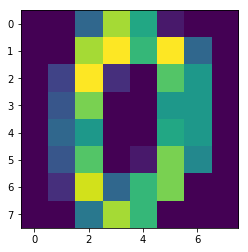

In [18]:
plt.imshow(X_temp[0].reshape(8,8))

(64,)

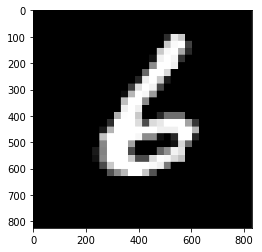

In [14]:
#plt.imshow(X_temp[0].reshape(8,8))
plt.imshow(img)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


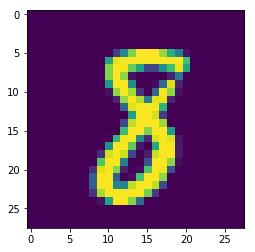

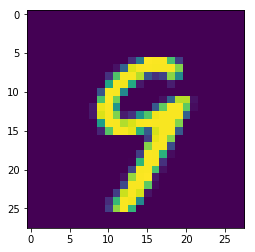

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

# Get a batch of two random images and show in a pop-up window.
batch_xs, batch_ys = mnist.test.next_batch(2)
gen_image(batch_xs[0]).show()
gen_image(batch_xs[1]).show()

In [16]:
import matplotlib
matplotlib.matplotlib_fname()

'C:\\Users\\Ron\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'